# Логистика химических продуктов

Задача относится к области моделирования ценообразования на
олигополистических рынках с использованием элементов теории игр. При этом
не требуется каких-то специальных знаний по теории игр, задача решается из
общих соображений.
Рассмотрим гипотетический рынок химического продукта, используемого
в промышленности для изготовления растворителей и синтеза полимеров.
Допустим, что имеется три производителя данного продукта и четыре крупных
покупателя, другие покупатели являются слишком мелкими и их влиянием
можно пренебречь. Предположим, что все три производителя производят
абсолютно одинаковый продукт и у покупателей на внутреннем рынке нет
никаких предпочтений относительно выбора того или иного производителя
кроме цены.
Поставки продукта от производителя покупателям производятся по
железной дороге в цистернах за счет производителя, т.е. расходы на перевозку
прибавляются к расходам производителя. Тариф на перевозку зависит от
расстояния доставки. Каждый производитель может доставить продукт до
любого покупателя, при этом понеся соответствующие расходы за
транспортировку. Также у любого поставщика есть возможность доставить
любое количество своего продукта по железной дороге в морской порт, откуда
его можно продать зарубежным покупателям по некоторой фиксированной цене,
не зависящей от количества продукта (т.е. цена продажи 1 тонны и 10 000 тонн
продукта будет одинаковой). Предположим, что все поставщики действуют
рационально. Также примем, что если один из них может повысить свою
прибыль понизив цену и забрав долю рынка у конкурентов, то он непременно
сделает это. Цена, по которой можно продать продукт в порту, составляет 50
долларов за тонну.
Покупателями продукта на внутреннем рынке являются крупные
промышленные компании. При этом потребности покупателей неэластичны по
цене в диапазоне до 100 долларов за тонну продукта, а при большей цене
покупатели откажутся от покупки. Каждый покупатель приобретает
фиксированное количество продукта каждый месяц. Примем, что покупатель
гарантированно меняет поставщика, если ему предлагается цена на ниже той,
по которой он покупает в настоящее время.
Данные по рынку представлены в таблицах 1-3.

# Задача

 Задача заключается в том, чтобы определить, кто у кого и по каким ценам
будет покупать продукт после того, как рынок придет в состояние равновесия,
т.е. когда ни у кого из производителей не будет мотивации менять цены или
объемы поставок. Важным моментом является то, что необходимо найти именно
верхнюю границу такого равновесия, т.е. набор максимальных возможных
равновесных цен поставок. На рынке, работающем по описанным правилам,
цены сами придут к уровню максимальных, если в начальный момент они были
заведомо больше (скажем, если максимальные равновесные цены находятся в
районе 50 долларов, а в начальный момент времени они были, допустим, 70
долларов).

# Библиотеки

In [840]:
import pandas as pd
import docplex.mp as dpx
import cplex
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

boldText = '\033[1m'

In [841]:
#pip install networkx

# Исходные данные модели

In [842]:
# Данные по поставщикам
NProds = 3
d = 50
ProdIndex=['Producer1', 'Producer2', 'Producer3']
ProdData = {'Possibilities': [890,534,1153],
            'SupplyPort': [18,13,18],
            'ProdCost': [12,21,10],
            'PortPrice': [d,d,d],
            'Overhead': [18+12,13+21,18+10]
             }
Producers = pd.DataFrame(ProdData, ProdIndex)

In [843]:
print(boldText+'Таблица 1. Данные по поставщикам')
Producers

Таблица 1. Данные по поставщикам


,Possibilities,SupplyPort,ProdCost,PortPrice,Overhead
Producer1,890,18,12,50,30
Producer2,534,13,21,50,34
Producer3,1153,18,10,50,28


In [844]:
Producers.index

Index(['Producer1', 'Producer2', 'Producer3'], dtype='object')

Данные по поставщикам



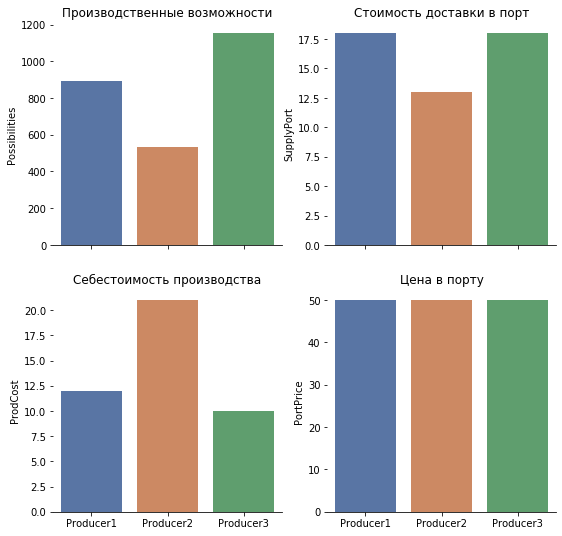

In [845]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharex=True)
sns.despine(left=True)

sns.barplot(x=Producers.index,
            y='Possibilities',
            data=Producers,
            palette="deep",
            ax=axes[0, 0]).set_title('Производственные возможности')

sns.barplot(x=Producers.index,
            y='SupplyPort',
            data=Producers,
            palette="deep",
            ax=axes[0, 1]).set_title('Стоимость доставки в порт')

sns.barplot(x=Producers.index,
            y='ProdCost',
            data=Producers,
            palette="deep",
            ax=axes[1, 0]).set_title('Себестоимость производства')

sns.barplot(x=Producers.index,
            y='PortPrice',
            data=Producers,
            palette="deep",
            ax=axes[1, 1]).set_title('Цена в порту')

print(boldText+'Данные по поставщикам\n')

plt.show()

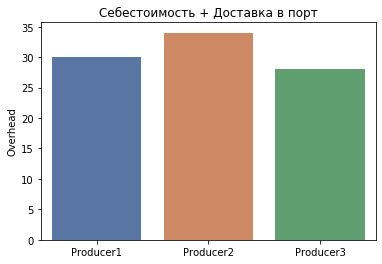

In [846]:
sns.barplot(x=Producers.index,
            y='Overhead',
            data=Producers,
            palette="deep").set_title('Себестоимость + Доставка в порт')
plt.show()

Преимущество в этом показателе даёт возможность варьироваь
ценой в более широком диапазоне при поставке продуктов покупателям

In [847]:
# Месячные потребности покупателей, тонн
NBuyers = 4
BuyersMaxPrice = 100
BuyIndex = ['Buyer1','Buyer2','Buyer3','Buyer4']
BuyData = {'Scenario1': [78,121,94,85], 'Scenario2': [117,670,193,279]}
#BuyData = {'Scenario1': [974+1,121,94,85], 'Scenario2': [117,670,193,279]}
Buyers = pd.DataFrame(BuyData, BuyIndex)

In [848]:
print(boldText+'Таблица 2. Месячные потребности покупателей, тонн')
Buyers

Таблица 2. Месячные потребности покупателей, тонн


,Scenario1,Scenario2
Buyer1,78,117
Buyer2,121,670
Buyer3,94,193
Buyer4,85,279


In [849]:
#выбор сценария
Scenario = Buyers.columns[0] # 0 - Scenario1
                             # 1 - Scenario2
print(Scenario)

Scenario1


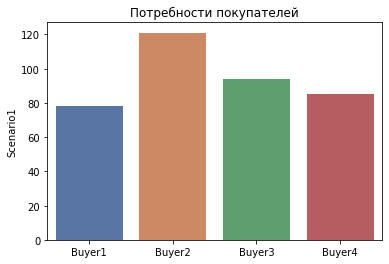

In [850]:
sns.barplot(x=Buyers.index,
            y='Scenario1',
            data=Buyers,
            palette="deep").set_title('Потребности покупателей')
plt.show()

In [851]:
# Тарифы на железнодорожные перевозки
RailData = {'Producer1':[14,23,21,42], 'Producer2':[26,10,19,36], 'Producer3':[15,38,18,15]}
RailFares = pd.DataFrame(RailData, BuyIndex)

In [852]:
print(boldText+'Таблица 3. Тарифы на железнодорожные перевозки')
RailFares

Таблица 3. Тарифы на железнодорожные перевозки


,Producer1,Producer2,Producer3
Buyer1,14,26,15
Buyer2,23,10,38
Buyer3,21,19,18
Buyer4,42,36,15


In [853]:
RailFares['Producer1']['Buyer1']

14

Тарифы на ЖД перевозки


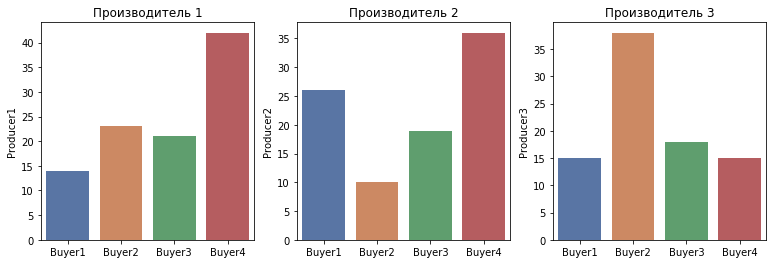

In [854]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharex=True)
#sns.despine(left=True)

sns.barplot(x=RailFares.index,
            y='Producer1',
            data=RailFares,
            palette="deep",
            ax=axes[0]).set_title('Производитель 1')

sns.barplot(x=RailFares.index,
            y='Producer2',
            data=RailFares,
            palette="deep",
            ax=axes[1]).set_title('Производитель 2')

sns.barplot(x=RailFares.index,
            y='Producer3',
            data=RailFares,
            palette="deep",
            ax=axes[2]).set_title('Производитель 3')

print(boldText+'Тарифы на ЖД перевозки')
plt.show()

In [855]:
totCost = RailFares + Producers['ProdCost']

Тарифы на ЖД перевозки + Себестоимость производства


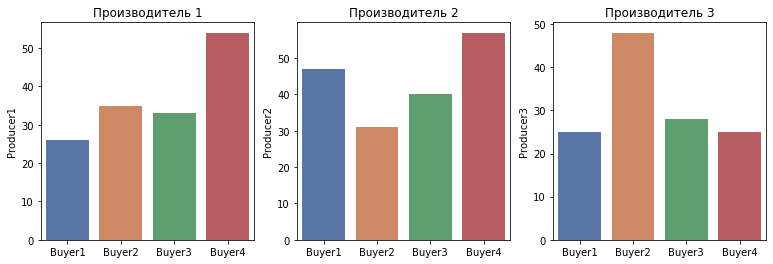

In [856]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharex=True)
#sns.despine(left=True)

sns.barplot(x=totCost.index,
            y='Producer1',
            data=totCost,
            palette="deep",
            ax=axes[0]).set_title('Производитель 1')

sns.barplot(x=totCost.index,
            y='Producer2',
            data=totCost,
            palette="deep",
            ax=axes[1]).set_title('Производитель 2')

sns.barplot(x=totCost.index,
            y='Producer3',
            data=totCost,
            palette="deep",
            ax=axes[2]).set_title('Производитель 3')

print(boldText+'Тарифы на ЖД перевозки + Себестоимость производства')
plt.show()

Здесь видно, что например, минимальные накладные расходы для доставки товаров второму покупателю имеет второй производитель.
Однако, за счёт большего приимущества первого производителя по накладным расходам доставки продуктов в порт конкурентную борьбу по минимальной предложенной цене выигрывает он.

In [857]:
# Тарифы на жд перевозки от i-го производителя j-му покупателю + себестоимость производства i-го производителя
k = np.zeros((NProds, NBuyers)).astype(int)
i=0
j=0
for prod, pcost in zip(RailFares, Producers['ProdCost']): # перебор по Producers
    j=0
    for rfares in RailFares[prod]:
        k[i,j] = rfares + pcost
        j+=1
    i+=1

In [858]:
# Тарифы на жд перевозки в порт + себестоимость производства i-го производителя 
z = np.empty(NProds).astype(int)
i=0
for SupplyPort, ProdCost in zip(Producers['SupplyPort'], Producers['ProdCost']):
    z[i] = SupplyPort + ProdCost
    i+=1

In [859]:
print('Тарифы на жд перевозки в порт + себестоимость производства i-го производителя')
print(z)

Тарифы на жд перевозки в порт + себестоимость производства i-го производителя
[30 34 28]


<img style="float: left;" src="files/MinMaxPrice.png">

In [860]:
#Максимальная выгодная цена для продажи
ProdBestPrices = np.zeros((NProds, NBuyers)).astype(int)

In [861]:
for j in range(NBuyers):
    i=0
    for portPrice, supplyPort, supplyProd in zip(Producers['PortPrice'], Producers['SupplyPort'], k[:,j]):
#       print(portPrice, supplyPort, supplyProd)
        ProdBestPrices[i,j] = portPrice-supplyPort+1+supplyProd
        i+=1

In [862]:
print(boldText+'Максимальная выгодные цены для продажи:')
ProdBestPrices

Максимальная выгодные цены для продажи:


array([[59, 68, 66, 87],
       [85, 69, 78, 95],
       [58, 81, 61, 58]])

In [863]:
#Матрица спроса покупателей
h = np.zeros((NProds, NBuyers)).astype(int)
for j in range(NBuyers):
    min_idxs = np.argmin(ProdBestPrices[:,j])
    h[min_idxs, j] = 1

print(boldText+'Матрица спроса покупателей')
h

Матрица спроса покупателей


array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 1]])

# Решение задачи

Задача заключается в том, чтобы определить, кто у кого и по каким ценам
будет покупать продукт после того, как рынок придет в состояние равновесия,
т.е. когда ни у кого из производителей не будет мотивации менять цены или
объемы поставок. Важным моментом является то, что необходимо найти именно
верхнюю границу такого равновесия, т.е. набор максимальных возможных
равновесных цен поставок. На рынке, работающем по описанным правилам,
цены сами придут к уровню максимальных, если в начальный момент они были
заведомо больше (скажем, если максимальные равновесные цены находятся в
районе 50 долларов, а в начальный момент времени они были, допустим, 70
долларов).
Необходимо заполнить таблицу 4 ценами и объемами поставок.

# Построение модели

In [864]:
from docplex.mp.model import Model
mdl = dpx.model.Model("ChemProd")

# Переменные решения

Определим переменные решения:

 - xij – количество тонн продукта поставленное от i-го производителя j-му покупателю;
 - yij – цена за тонну продукта i-го производителя j-му покупателю;
 - rij – есть или нету (1-есть, 0-нету) поставка продукта от i-го производителя j-му покупателю;
 - si – есть или нету (1-есть, 0-нету) поставка продукта от i-го производителя в порт.

In [865]:
# матрица решений, показывающая количество тонн продукта поставленное от i-го производителя j-му покупателю
# столбец-производитель; строка-покупатель
x = mdl.integer_var_matrix(NProds, NBuyers, name=lambda ij: "ProdVol_to_Buyer%d_%d" %(ij[0], ij[1]))

In [866]:
# матрица решений, показывающая цену за тонну продукта i-го производителя j-му покупателю
# столбец-производитель; строка-покупатель
y = mdl.integer_var_matrix(NProds, NBuyers, name=lambda ij: "ProdPrice_to_Buyer%d_%d" %(ij[0], ij[1]))

In [867]:
# вектор решений - количество продукта перевнзённое в порт
p = mdl.integer_var_list(NProds, name='ProdVol_to_port')

# Ограничения модели

<img style="float: left;" src="files/constrains.png">

1.	Ограничения по количеству тонн поставляемого продукта

In [868]:
# Ограничения по количеству тонн производимого продукта для производителей
for i, possib, cts_name in zip(range(NProds), Producers['Possibilities'], Producers['Possibilities'].index):
    mdl.add_constraint(mdl.sum(x[i,j] for j in range(NBuyers)) + p[i] <= possib, ctname='Possib'+cts_name)

2.	Ограничения по потребностям покупателей

In [869]:
# Ограничения по потребностям покупателей для покупателей
for j, req, buyer in zip(range(NBuyers), Buyers[Scenario], Buyers[Scenario].index):
    mdl.add_constraint(mdl.sum(x[i,j] for i in range(NProds)) == req,  ctname=buyer+'Need')

3.	Ограничения по максимальной и минимальной цене продукта

In [870]:
# Ограничения по цене продукта
for i in range(NProds):
    for j in range(NBuyers):
        #mdl.add_constraints( [y[i,j] <= BuyersMaxPrice, y[i,j] >= 0], ['BuyersMaxPrice', 'BuyersMinPrice'])
        mdl.add_constraint( y[i,j] == ProdBestPrices[i,j], 'ProdBestPrices')

In [871]:
print('Информация о модели')
mdl.print_information()

Информация о модели
Model: ChemProd
 - number of variables: 27
   - binary=0, integer=27, continuous=0
 - number of constraints: 19
   - linear=19
 - parameters: defaults
 - problem type is: MILP


# Целевая функция

<img style="float: left;" src="files/target_func.png">

In [872]:
#Доставка покупателям
SalesBuyers = mdl.sum( (y[i,j]-k[i,j])*x[i,j]*h[i,j] for i in range(NProds) for j in range(NBuyers) ) 
#SalesBuyers = mdl.sum( (y[i,j]-k[i,j])*x[i,j] for i in range(NProds) for j in range(NBuyers) ) 
#Доставка в порт
SalesPort = mdl.sum( (d-z[i])*p[i] for i in range(NProds) )
#Целевая функция
mdl.maximize(SalesBuyers + SalesPort)

# Решение для модели

In [873]:
mdl.print_information()

assert mdl.solve(), "!!! Solve of the model fails"

Model: ChemProd
 - number of variables: 27
   - binary=0, integer=27, continuous=0
 - number of constraints: 19
   - linear=19
 - parameters: defaults
 - problem type is: MIQP


In [874]:
prodsVol = np.zeros((NProds, NBuyers)).astype(int)
prodsPrice = np.zeros((NProds, NBuyers)).astype(int)
VolPrice = np.zeros((NProds, NBuyers)).astype(int)
VolPricePort = []
for i in range(NProds):
    VolPricePort.append((d - z[i])*p[i].solution_value)
    for j in range(NBuyers):
        prodsVol[i,j] = x[i,j].solution_value
#        prodsVol[i,j] = x[1,j].solution_value
        prodsPrice[i,j] = y[i,j].solution_value
        VolPrice[i,j] = (y[i,j].solution_value - k[i,j])*x[i,j].solution_value
#       VolPrice[i,j] = (y[i,j].solution_value - k[i,j])*x[1,j].solution_value*demand[i,j]

VolData = {'Producer1':prodsVol[0], 'Producer2':prodsVol[1], 'Producer3':prodsVol[2]}
DecisionVol = pd.DataFrame(VolData, BuyIndex)

PriceData = {'Producer1':prodsPrice[0], 'Producer2':prodsPrice[1], 'Producer3':prodsPrice[2]}
DecisionPrice = pd.DataFrame(PriceData, BuyIndex)

VolPriceData = {'Producer1':VolPrice[0], 'Producer2':VolPrice[1], 'Producer3':VolPrice[2]}
DecisionVolPrice = pd.DataFrame(VolPriceData, BuyIndex)

In [875]:
print(boldText+'Количество тонн продукта поставленное от i-го производителя j-му покупателю')
DecisionVol

Количество тонн продукта поставленное от i-го производителя j-му покупателю


,Producer1,Producer2,Producer3
Buyer1,0,0,78
Buyer2,121,0,0
Buyer3,0,0,94
Buyer4,0,0,85


In [876]:
print(boldText+'Цена за тонну продукта i-го производителя j-му покупателю')
DecisionPrice

Цена за тонну продукта i-го производителя j-му покупателю


,Producer1,Producer2,Producer3
Buyer1,59,85,58
Buyer2,68,69,81
Buyer3,66,78,61
Buyer4,87,95,58


In [877]:
print(boldText+'Объём продаж i-го производителя j-му покупателю за вычетом затрат на доставку товара')
DecisionVolPrice

Объём продаж i-го производителя j-му покупателю за вычетом затрат на доставку товара


,Producer1,Producer2,Producer3
Buyer1,0,0,2574
Buyer2,3993,0,0
Buyer3,0,0,3102
Buyer4,0,0,2805


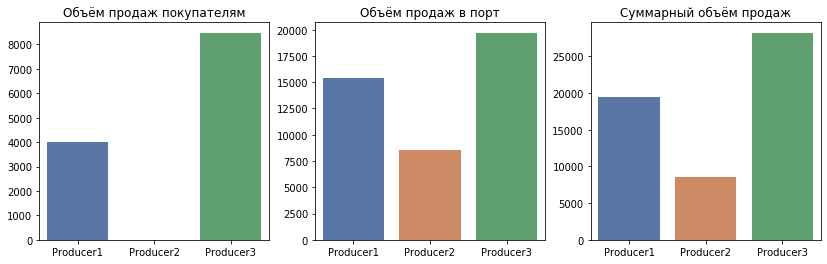

In [878]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharex=True)

sns.barplot(x=DecisionVolPrice.columns,
            y=[DecisionVolPrice['Producer1'].sum(),
               DecisionVolPrice['Producer2'].sum(),
               DecisionVolPrice['Producer3'].sum()],
            palette="deep",
            ax=axes[0]).set_title('Объём продаж покупателям')

sns.barplot(x=DecisionVolPrice.columns,
            y=[VolPricePort[0],
               VolPricePort[1],
               VolPricePort[2]],
            palette="deep",
            ax=axes[1]).set_title('Объём продаж в порт')

p1 = DecisionVolPrice['Producer1'].sum()+VolPricePort[0]
p2 = DecisionVolPrice['Producer2'].sum()+VolPricePort[1]
p3 = DecisionVolPrice['Producer3'].sum()+VolPricePort[2]
sns.barplot(x=DecisionVolPrice.columns,
            y=[p1,p2,p3],
            palette="deep",
            ax=axes[2]).set_title('Суммарный объём продаж')

plt.show()

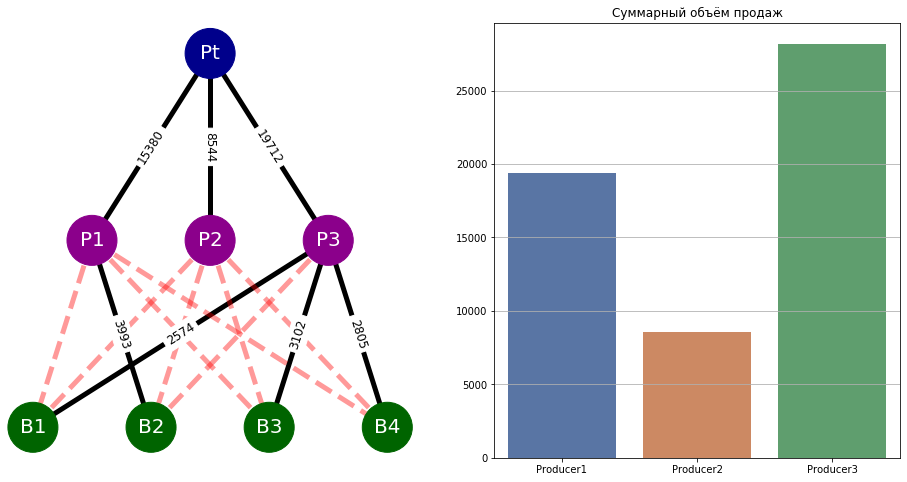

In [879]:
G = nx.Graph()
#Морской порт
G.add_edge('P1', 'Pt', w=VolPricePort[0])
G.add_edge('P2', 'Pt', w=VolPricePort[1])
G.add_edge('P3', 'Pt', w=VolPricePort[2])
#
G.add_edge('P1', 'B1', w=DecisionVolPrice['Producer1']['Buyer1'])
G.add_edge('P2', 'B1', w=DecisionVolPrice['Producer2']['Buyer1'])
G.add_edge('P3', 'B1', w=DecisionVolPrice['Producer3']['Buyer1'])

G.add_edge('P1', 'B2', w=DecisionVolPrice['Producer1']['Buyer2'])
G.add_edge('P2', 'B2', w=DecisionVolPrice['Producer2']['Buyer2'])
G.add_edge('P3', 'B2', w=DecisionVolPrice['Producer3']['Buyer2'])

G.add_edge('P1', 'B3', w=DecisionVolPrice['Producer1']['Buyer3'])
G.add_edge('P2', 'B3', w=DecisionVolPrice['Producer2']['Buyer3'])
G.add_edge('P3', 'B3', w=DecisionVolPrice['Producer3']['Buyer3'])

G.add_edge('P1', 'B4', w=DecisionVolPrice['Producer1']['Buyer4'])
G.add_edge('P2', 'B4', w=DecisionVolPrice['Producer2']['Buyer4'])
G.add_edge('P3', 'B4', w=DecisionVolPrice['Producer3']['Buyer4'])

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['w'] > 0]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['w'] == 0]

pos = {
       'P1':[-1,1],'Pt':[0,2],
       'P2':[0,1], 'Pt':[0,2],
       'P3':[1,1], 'Pt':[0,2], 
    
       'P1':[-1,1],'B1':[-1.5,0],
       'P2':[0,1], 'B1':[-1.5,0],
       'P3':[1,1], 'B1':[-1.5,0],
    
       'P1':[-1,1],'B2':[-0.5,0],
       'P2':[0,1], 'B2':[-0.5,0],
       'P3':[1,1], 'B2':[-0.5,0],
    
       'P1':[-1,1],'B3':[0.5,0],
       'P2':[0,1], 'B3':[0.5,0],
       'P3':[1,1], 'B3':[0.5,0],
    
       'P1':[-1,1],'B4':[1.5,0],
       'P2':[0,1], 'B4':[1.5,0],
       'P3':[1,1], 'B4':[1.5,0]
       }

plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)

nodes_color = ('darkmagenta','darkblue','darkmagenta','darkmagenta','darkgreen','darkgreen','darkgreen','darkgreen')
#nodes_size = (p1, 2500, p2, p3, 2500, 2500, 2500, 2500)
nx.draw_networkx_nodes(G, pos=pos, node_size=2500, node_color=nodes_color)

nx.draw_networkx_edges(G, pos=pos, edgelist=elarge,
                       width=5, edge_color='black')

nx.draw_networkx_edges(G, pos=pos, edgelist=esmall,
                       width=5, alpha=0.4, edge_color='red', style='dashed')

edge_values = []
for (u, v, d) in G.edges(data=True):
    if d['w']>0:
        edge_values.append(int(d['w']))
        
labels = dict(zip(elarge, edge_values))

nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels, font_size=12, font_color='black')

# labels
nx.draw_networkx_labels(G, pos=pos, font_size=20, font_color='white')

plt.axis('off')
plt.subplot(1,2,2)
plt.grid(True)
sns.barplot(x=DecisionVolPrice.columns,
            y=[p1,p2,p3],
            palette="deep").set_title('Суммарный объём продаж')

#plt.axis('off')
#print(boldText+'Визуализация модели\n')
plt.show()